# Experiment Results for UMLP & UCNN
This notebook analyses / plots the results for the Unification MLP and Unification CNN networks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's accumulate the data into a csv from raw log files:

In [2]:
%%bash
for type in umlp ucnn urnn; do
  python3 utils/umlp_ucnn_process_logs.py -hd "$type"_result/*_log.json > "$type"_results.csv
  python3 utils/umlp_ucnn_process_logs.py "$type"_result/*_log.json >> "$type"_results.csv
done

In [3]:
# Load respective data
df_umlp = pd.read_csv("umlp_results.csv")
# UMLP has an extra length column which is fixed and we don't need
df_umlp = df_umlp.drop(columns=['length', 'symbols'])
df_ucnn = pd.read_csv("ucnn_results.csv")
df_ucnn = df_ucnn.drop(columns=['symbols'])
df_urnn = pd.read_csv("urnn_results.csv")
df_urnn = df_urnn.drop(columns=['length'])
df = pd.concat([df_umlp, df_ucnn, df_urnn])

# The dataframe contain the training results at each iteration with experiment details
df.sample(5)

,name,invariants,embed,tsize,fold,main/uloss,main/uacc,main/igloss,main/igacc,main/oloss,...,test/main/uloss,test/main/uacc,test/main/igloss,test/main/igacc,test/main/oloss,test/main/oacc,test/main/vloss,epoch,iteration,elapsed_time
5908,umlp,2,16,50,4,0.006695,1.000000,0.002417,1.0,3.490937,...,0.644143,0.896267,0.002377,1.0,4.119913,0.454427,-72.524643,348,1090,114.642843
1745,basecnn,1,32,50,3,2.963394,0.217188,0.000191,1.0,0.000147,...,3.718471,0.160691,0.000189,1.0,3.665779,0.294819,0.000000,537,1460,131.131942
5885,ucnn,2,32,50,4,0.012954,0.998437,0.000214,1.0,5.434148,...,2.184491,0.692508,0.000182,1.0,6.806067,0.250841,-54.636703,312,860,98.386721
8471,ucnn,4,32,0,2,0.019875,0.998437,0.000903,1.0,4.025819,...,0.013118,1.000000,0.000752,1.0,4.307817,0.283346,-90.371483,20,720,120.576125
1411,basecnn,1,32,50,2,2.763854,0.182812,0.024780,1.0,0.022849,...,3.123358,0.135016,0.022041,1.0,2.423907,0.312861,0.000000,42,120,10.730361


In [4]:
# We'll create some extra computed columns for convenience
df['unification'] = ~df['name'].str.contains('base', regex=False) # Do we have unification enabled?
df['type'] = df['name'].apply(lambda s: s[-3:]) # What network type is this?
df['test/acc'] = df['test/main/uacc'].where(df.unification, df['test/main/oacc']) # Which test accuracy to pick?
df['test/er'] = 1-df['test/acc'] # Test error rate
df.sample(5)

,name,invariants,embed,tsize,fold,main/uloss,main/uacc,main/igloss,main/igacc,main/oloss,...,test/main/oloss,test/main/oacc,test/main/vloss,epoch,iteration,elapsed_time,unification,type,test/acc,test/er
5900,ucnn,2,32,50,4,0.012440,1.000000,0.000122,1.0,5.943190,...,7.097378,0.255529,-64.828232,367,1010,115.619312,True,cnn,0.692508,0.307492
5229,ucnn,2,32,50,1,0.019913,1.000000,0.005363,1.0,2.566450,...,3.819303,0.238438,-17.864502,107,300,34.052329,True,cnn,0.683125,0.316875
6287,umlp,3,16,0,1,0.025609,0.996875,0.004773,1.0,3.873964,...,4.197638,0.354924,-79.224571,20,880,139.761486,True,mlp,0.996094,0.003906
552,basecnn,1,32,0,2,9.205405,0.125000,0.000160,1.0,0.001472,...,0.826672,0.793006,0.000000,44,1530,143.857576,False,cnn,0.793006,0.206994
6264,urnn,3,16,1000,1,0.038239,0.982812,0.171791,1.0,0.099646,...,0.146144,0.942077,0.325942,20,650,258.114330,True,rnn,0.946654,0.053346


## Does unification help with generalisation?
We will plot the test accuracy over iterations to see if unification helps with generalisation. We will take a single invariant case. Note base line also has single invariant although it doesn't use it, it is required to check if training the baseline for some reason also improves unification haphazardly.

In [5]:
# Filter data to get single invariants
df1 = df[(df.invariants == 1)]

# Adjust column names and types for plotting
df1['type'] = df1['type'].str.upper()
df1['unification'] = np.where(df1.unification, 'Yes', 'No')
df1['tsize'] = np.where((df1.tsize == 0) | (df1.tsize == 1000), '≤ 1000', '≤ 50')
df1 = df1.rename(columns={'unification': 'Unification', 'tsize': 'Training Size'})
df1.sample(5)

/data/nuric/pypi/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/data/nuric/pypi/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/data/nuric/pypi/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,name,invariants,embed,Training Size,fold,main/uloss,main/uacc,main/igloss,main/igacc,main/oloss,...,test/main/oloss,test/main/oacc,test/main/vloss,epoch,iteration,elapsed_time,Unification,type,test/acc,test/er
3060,umlp,1,16,≤ 50,0,0.009242,1.000000,0.002941,1.0,5.079627,...,5.022699,0.325175,-17.272430,195,610,50.651515,Yes,MLP,0.917676,0.082324
197,basemlp,1,16,≤ 1000,0,4.328227,0.485938,0.004618,1.0,0.018299,...,0.135794,0.953691,0.000000,46,1980,162.735199,No,MLP,0.953691,0.046309
458,basernn,1,16,≤ 1000,2,0.671618,0.653125,0.031626,1.0,0.125034,...,0.181317,0.933036,0.439451,18,590,153.647770,No,RNN,0.933036,0.066964
2551,umlp,1,16,≤ 1000,2,0.004690,1.000000,0.000540,1.0,9.451059,...,9.266148,0.362659,-44.739326,35,1520,125.958825,Yes,MLP,0.992471,0.007529
3583,ucnn,1,32,≤ 50,2,0.009066,1.000000,0.001626,1.0,14.609593,...,19.716905,0.269107,-54.779900,676,1840,176.777548,Yes,CNN,0.632455,0.367545


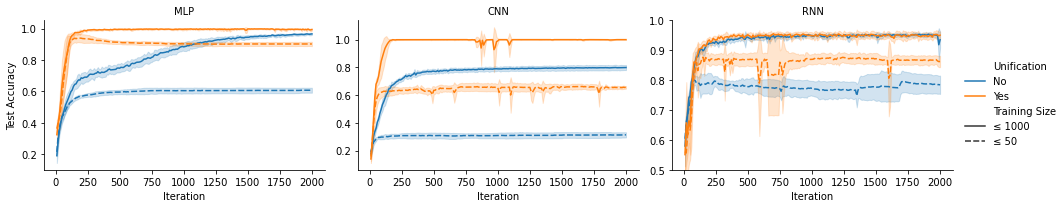

In [6]:
# Plot the test accuracy
g = sns.relplot(x='iteration', y='test/acc', hue='Unification',
                style='Training Size', kind='line', col='type', ci='sd',
                height=3, aspect=1.5, facet_kws={'sharey': False}, data=df1)
g.set_titles("{col_name}")
g.set_ylabels("Test Accuracy")
g.set_xlabels("Iteration")
plt.ylim(0.1, 1.0)
g.facet_axis(0, 2).set_ylim(0.5, 1.0)
g.savefig("umlp_ucnn_acc_plot.pdf", bbox_inches='tight')

## What is the effect of having more invariants?
We are now interested in increasing the number of invariants and looking at the change in performance. Since the tasks can be solved with a single invariant already, is there performance benefit of using multiple?

In [7]:
# Let's take only the unification cases
dfu = df[df.unification]

# Fix column names etc. for plotting
dfu['type'] = dfu['type'].str.upper()
dfu['tsize'] = np.where((dfu.tsize == 0) | (dfu.tsize == 1000), '≤ 1000', '≤ 50')
dfu = dfu.rename(columns={'tsize': 'Training Size'})

dfu.sample(5)

/data/nuric/pypi/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/data/nuric/pypi/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,name,invariants,embed,Training Size,fold,main/uloss,main/uacc,main/igloss,main/igacc,main/oloss,...,test/main/oloss,test/main/oacc,test/main/vloss,epoch,iteration,elapsed_time,unification,type,test/acc,test/er
5297,urnn,2,16,≤ 50,1,0.000092,1.000000,0.012502,1.0,0.008936,...,1.049229,0.772885,0.226642,627,980,359.020434,True,RNN,0.843908,0.156092
7027,umlp,3,16,≤ 50,0,0.023029,1.000000,0.022399,1.0,2.324718,...,2.426336,0.357055,-24.743658,89,280,44.234993,True,MLP,0.932765,0.067235
5395,ucnn,2,32,≤ 50,1,0.067081,0.967187,0.000738,1.0,6.911679,...,9.569402,0.265938,-128.723969,700,1960,225.549032,True,CNN,0.726250,0.273750
4577,urnn,2,16,≤ 1000,2,0.021344,0.990625,0.014963,1.0,0.049848,...,0.161710,0.950528,0.278130,56,1780,619.673374,True,RNN,0.957386,0.042614
4982,umlp,2,16,≤ 1000,4,0.006945,1.000000,0.000814,1.0,7.516735,...,8.056207,0.295701,-117.589447,42,1830,194.708773,True,MLP,0.998698,0.001302


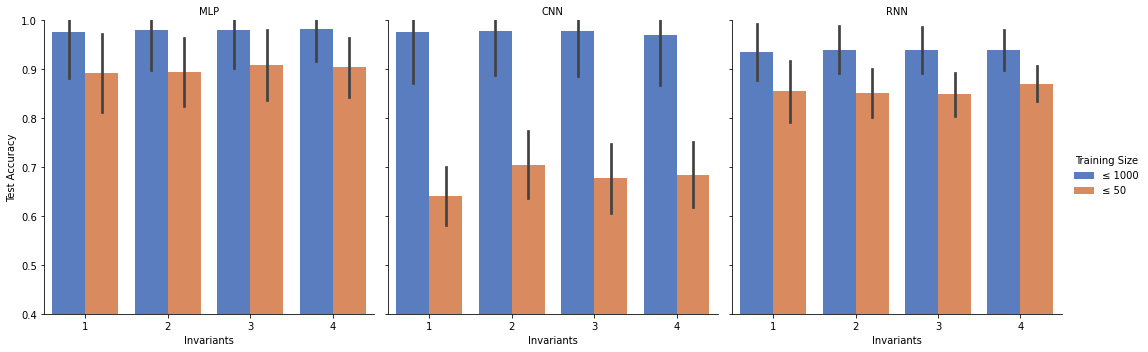

In [8]:
# Plot the test accuracy
g = sns.catplot(x='invariants', y='test/acc', hue='Training Size',
                col='type', kind='bar', ci='sd', data=dfu, palette='muted')
g.set_titles("{col_name}")
g.set_ylabels("Test Accuracy")
g.set_xlabels("Invariants")
plt.ylim(0.4, 1.0)
g.savefig("umlp_ucnn_invs_plot.pdf", bbox_inches='tight')

In [9]:
# And in tabular format
pd.pivot_table(dfu, index='invariants', columns=['type', 'Training Size'],
               values='test/acc', aggfunc=[np.mean, np.std]).round(2)

mean                                    std               \
type             CNN          MLP          RNN          CNN          MLP   
Training Size ≤ 1000  ≤ 50 ≤ 1000  ≤ 50 ≤ 1000  ≤ 50 ≤ 1000  ≤ 50 ≤ 1000   
invariants                                                                 
1               0.98  0.64   0.98  0.89   0.94  0.86   0.10  0.06   0.09   
2               0.98  0.70   0.98  0.89   0.94  0.85   0.09  0.07   0.08   
3               0.98  0.68   0.98  0.91   0.94  0.85   0.09  0.07   0.08   
4               0.97  0.68   0.98  0.90   0.94  0.87   0.10  0.07   0.07   

                                  
type                   RNN        
Training Size  ≤ 50 ≤ 1000  ≤ 50  
invariants                        
1              0.08   0.06  0.06  
2              0.07   0.05  0.05  
3              0.07   0.05  0.04  
4              0.06   0.04  0.04

# Visualising an invariant
Here we take an invariant from the sentiment analysis task and visualise the variableness of each of the symbols in the sentence.

In [10]:
import re
# Load the output file
train_size = 50 # 50 or 1000
fold_id = 4 # range(5)
outf = f"urnn_result/urnn_l20_i1_e16_t{train_size}_f{fold_id}.out"
with open(outf, 'r') as f:
    outs = f.read().splitlines() # Gets without trailing \n
# Find and get invariant
inv_str = outs[outs.index('Inv:') + 1].split(' -> ')
inv = eval(inv_str[0]) # ['vivid', 'with', ...]
label = int(inv_str[1]) # 1 for positive 0 for negative
# Find and get vmap
vmap = np.array(eval(re.sub('\s+', ',', outs[outs.index('vmap:') + 1].strip()[1:-1])))
# Combine them
inv_map = pd.DataFrame({'Symbol': inv, 'Variableness': vmap})

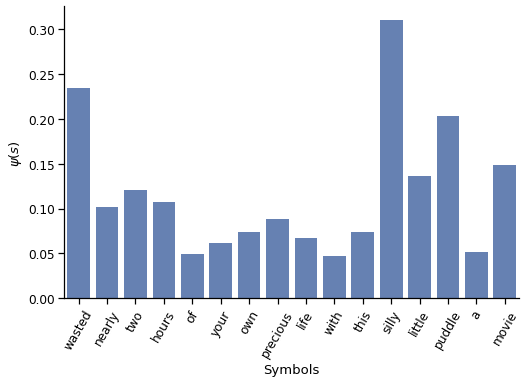

In [11]:
# Plot the vmap
sns.set_context("notebook", font_scale=1.1)
g = sns.catplot(x='Symbol', y='Variableness', kind='bar', data=inv_map, color='#597dbf', aspect=1.5)
#g.set_titles("Variable Map")
g.set_ylabels("$\psi(s)$")
g.set_xlabels("Symbols")
plt.xticks(rotation=60)
g.savefig("sentiment_inv.pdf", bbox_inches='tight')